In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import math
from sklearn import preprocessing
# Adjusting the size of matplotlib
import matplotlib as mpl
import datetime

In [2]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("PAH3.DE", start="2009-01-01").reset_index()
# df_full.to_csv('output/JPM.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-28,38.30,40.42,37.83,39.94,29.25,901567
1,2009-01-29,39.89,40.00,37.91,38.41,28.13,629475
2,2009-01-30,38.06,40.95,37.95,39.32,28.80,1467863
3,2009-02-02,37.01,37.42,35.65,36.11,26.93,1350452
4,2009-02-03,36.25,36.49,35.10,35.95,26.81,1183009


## Plot Moving Average

Rollin mean/Moving Average smoothsout our price data by creating a constantly updated average price

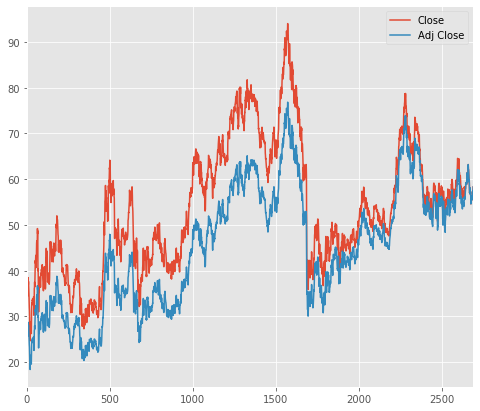

In [3]:
adj_close_px = df_full['Adj Close']
close_px = df_full['Close']
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Close')
adj_close_px.plot(label='Adj Close')
plt.legend()

In [4]:
close_px = df_full['Close']
mavg = close_px.rolling(window=100).mean()

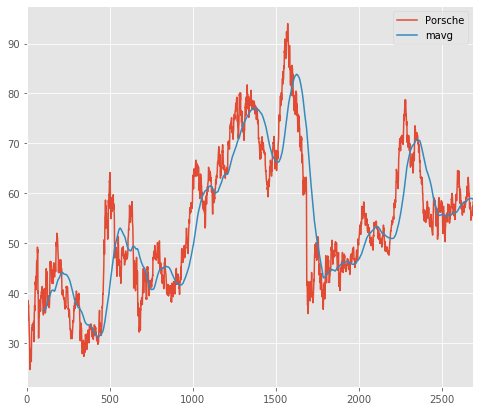

In [5]:
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Porsche')
mavg.plot(label='mavg')
plt.legend()

## Return Deviation

Expected Return measures the mean, or expected value, of the probability distribution of investment returns.

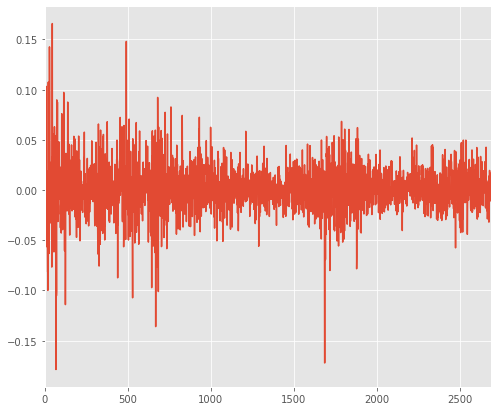

In [6]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

## Predict Stock Prices

In [7]:
df = df_full.loc[:,['Close','Volume','Low','High','Open']]

### Preprossesing
1. Drop missing values
2. Separating the label here, we want to predict the AdjClose
3. Scale the X so that everyone can have the same distribution for linear regression
4. Split data into train, validation and test set

In [8]:
# df.fillna(value=-99999, inplace=True)
# Print Data rows which are nan
df[df.isnull().any(axis=1)]

,Close,Volume,Low,High,Open


In [9]:
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Close'
df['label'] = df[forecast_col].shift(-1)
df = df.drop(df[df.isnull().any(axis=1)].index)
X = np.array(df.drop(['label'], 1))

In [30]:
df

,Close,Volume,Low,High,Open,label,Forecast
0,39.94,901567,37.83,40.42,38.30,38.41,NaN
1,38.41,629475,37.91,40.00,39.89,39.32,NaN
2,39.32,1467863,37.95,40.95,38.06,36.11,NaN
3,36.11,1350452,35.65,37.42,37.01,35.95,NaN
4,35.95,1183009,35.10,36.49,36.25,35.87,NaN
...,...,...,...,...,...,...,...
2685,56.02,327032,55.42,56.50,56.02,56.38,56.010749
2686,56.38,313636,55.36,56.98,55.58,57.06,56.368644
2687,57.06,403941,56.58,57.82,56.58,57.38,57.187435
2688,57.38,299411,56.56,57.46,57.20,57.32,57.250534


In [11]:
# We want to separate 10 percent of the data to forecast
forecast_out = int(math.ceil(0.1 * len(df)))

In [12]:
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

In [13]:
# Split the data into trainings data and test data
X_test = X[-forecast_out:]
X_train = X[:-forecast_out]

In [14]:
# Separate label and identify it as y
y = np.array(df['label'])
y_train = y[:-forecast_out]
y_test = y[-forecast_out:]

## Prediction

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Simple Linear Analysis

In [16]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### Quadratic Discriminant Analysis

In [17]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [18]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

## Ridge Regression

In [35]:
clfridge = Ridge(alpha=.5)
clfridge.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Lasso
The Lasso is a linear model that estimates sparse coefficients

In [33]:
clflasso = Lasso(alpha=0.1)
clflasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### K Nearest Neighbor

In [19]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

## Evaluation

In [20]:
df[-forecast_out:]

,Close,Volume,Low,High,Open,label
2421,57.14,487245,55.48,57.24,55.82,56.88
2422,56.88,395099,56.74,57.40,57.36,55.42
2423,55.42,588171,54.44,56.62,56.62,55.06
2424,55.06,338580,54.56,55.46,54.90,54.80
2425,54.80,287688,54.34,55.64,55.44,53.74
...,...,...,...,...,...,...
2685,56.02,327032,55.42,56.50,56.02,56.38
2686,56.38,313636,55.36,56.98,55.58,57.06
2687,57.06,403941,56.58,57.82,56.58,57.38
2688,57.38,299411,56.56,57.46,57.20,57.32


In [36]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceridge = clfridge.score(X_test,y_test)
confidencelasso = clflasso.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The Ridge regression confidence is ', confidenceridge)
print('The Lasso confidence is ', confidencelasso)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.8617124799800099
The quadratic regression 2 confidence is  0.8610550105332242
The quadratic regression 3 confidence is  0.8582881065507153
The Ridge regression confidence is  0.8616131802727759
The Lasso confidence is  0.8622109033432095
The knn regression confidence is  0.7560178962601587


In [25]:
# select the classifier to predict
forecast_set = clfpoly3.predict(X_test)

df['Forecast'] = np.nan
index = len(df)- forecast_out
for i in forecast_set:
    df['Forecast'].at[index] = i
    index += 1

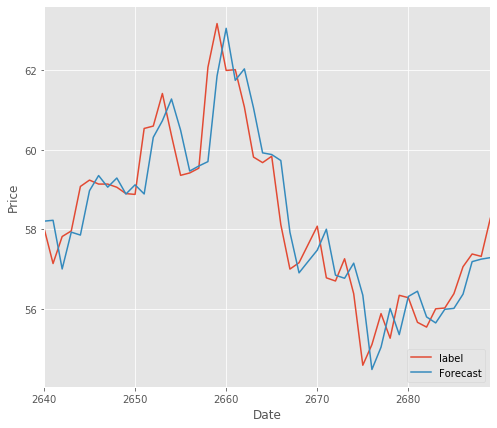

In [28]:
df['label'].tail(50).plot()
df['Forecast'].tail(50).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Results:
As you can see in the results of the Notebook even if the models seem to be not to bad, they are. So if you look closer, they just mimic what happend the day before. From that we can see that a regression model is not good enough to predict stock prices. To do that you should try to use other models and most important its not enough to use only past stock data. There for you could try to use Sentiment Analysis on twitter or news data to improve the model.